# Homework 4: SARS-CoV-2 variants - How fast does the virus evolve?

Viruses are not immune to mutations and evolution.
During the pandemic, the SARS-CoV-2 virus mutated, evolved, and changed its characteristics, leaving us with various new strains and variants.


The evolution of new strains is tied to their rate of mutation.
Therefore, we must know how fast they mutate to understand their evolution.
Their mutation rate is meaningless without some references; thus, we will compare it to the rate of mutations of other viruses.
Apart from the rate, the location of mutations is vital for evolving new characteristics while preserving their viability.
Some specific mutations give rise to a new variant, and we will be interested in where those mutations happen in different variants.
Lastly, we will focus on Slovenia and its variant landscape throughout the pandemic.

In [1]:
import numpy as np          
import pandas as pd         # for saving classification in P4
from Bio import SeqIO       # for reading fasta files
from Bio import Entrez
import matplotlib.pyplot as plt
import json

In [2]:
Entrez.email = "mm9520@student.uni-lj.si"

## Problem 1: Rate of mutation

How fast is the SARS-CoV-2 virus evolving? Can we empirically determine the speed of mutation? We can! Most biologists are very meticulous with their experiments and carefully document when samples are collected. We can then take a bunch of viral genomes, select a reference genome (usually the first known occurrence of the virus), and calculate the number of mutations from the reference to the remaining viral genomes. We can then use this information in conjunction with the sample collection dates to estimate how fast the viruses are evolving.

**Task:**
Implement the `jukes_cantor` function in `helper_functions.py` to calculate the genetic distance using Hamming distance and Jukes-Cantor correction. Note that Jukes-Cantor correction ignores insertions and deletions.

You have 211 SARS-CoV-2 genomes aligned to the reference (_NC_045512.2_).
You can find their collection date and country in their fasta description.

Find the first collected instance of SARS-CoV-2, i.e., the virus, with the earliest collection date. We'll use our NCBI reference (_NC_045512.2_) as a reference virus.
You can use a pandas function `pd.to_datetime()` to convert collection dates into a Timestamp. Timestamps without the explicit day of the month will convert into the first day of the month.

Calculate the genetic distance from the reference sequence to all other and plot its dependence on the time elapsed from this starting point.

Create a scatterplot of viruses, where you put genetic distance on the y-axis and time in days (the number of days since the starting point) on your x-axis. The earliest sequence should be located at the origin (0, 0).
Estimate the mutation rate using linear regression and overlay your plot with the regression line.

Report the mutation rate per genome per day and save it into the `sars_cov_2_per_genome_per_day` variable. 
Report the mutation rate per nucleotide per day and save it into the `sars_cov_2_per_nt_per_day` variable. 
Save the resulting figure into `problem1.png`.

**[10 points]** 

Hint: check out `np.polyfit` to fit the linear regression curve. Include your reference in the linear fit and account for the intersection when plotting your fit.

In [120]:
from helper_functions import jukes_cantor

In [121]:
def procedure(fasta, ignore_reference, ref=None):
    records = list(SeqIO.parse(f'./data/{fasta}', "fasta"))
    sequences = []
    dates = []
    reference = None
    for r in records:
        if ref is not None and r.description.split("|")[0] == ref: reference = r.seq
        sequences.append(r.seq)
        dates.append(pd.to_datetime(r.description.split("|")[2]))

    sequences = [x for _, x in sorted(zip(dates, sequences))]
    dates = sorted(dates)

    day_diffs = []
    distances = []
    if reference is None: reference = sequences[0]
    for i in range(ignore_reference, len(dates)):
        day_diffs.append((dates[i] - dates[0]) / np.timedelta64(1, 'D'))
        distances.append(jukes_cantor(reference, sequences[i]))

    return day_diffs, distances, sequences

In [122]:
day_diffs, distances, sequences = procedure("p1-sars-cov-2-variants.fasta", ignore_reference = False, ref = "NC_045512.2")
coef = np.polyfit(day_diffs, distances, 1)
lin = np.linspace(0, 700, 2)

In [123]:
coef[0]

0.06411742075609324

In [124]:
coef[0] / len(sequences[0])

2.158617673504132e-06

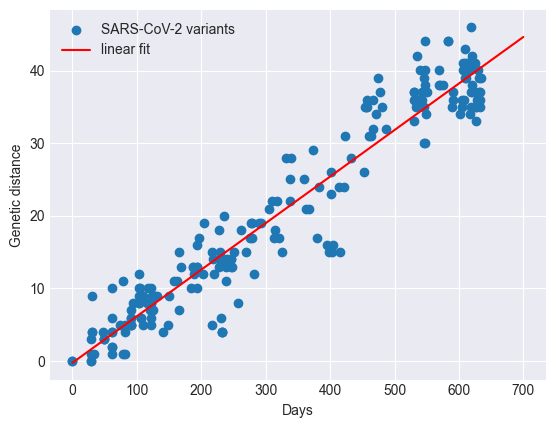

In [125]:
plt.style.use('seaborn-darkgrid')
plt.scatter(day_diffs, distances, label="SARS-CoV-2 variants")
plt.plot(lin, (coef[1] + lin*coef[0]), color="red", label="linear fit")
plt.xlabel("Days")
plt.ylabel("Genetic distance")
plt.legend()
# plt.savefig("problem1.png", dpi=500, bbox_inches="tight")

In [18]:
sars_cov_2_per_genome_per_day = 0.06411742075609324
sars_cov_2_per_nt_per_day = 2.158617673504132e-06

## Problem 2: Mutation rate in other viruses

We've estimated the regression slope to SARS-CoV-2. Now what? Does the plot indicate a fast mutation rate? Or a slow mutation rate? Or an average mutation rate? We really can only tell with a frame of reference. In this exercise, we will look at two more viruses from recent outbreaks, the Zaire ebolavirus, and Zika virus, and determine their mutation rate. These will help us get a sufficient reference for the speed at which viruses mutate.

**Task:**
Find the aligned sequences for Ebola and Zika virus in the `data/p2-ebola-viruses.fasta` and `data/p2-zika-viruses.fasta`.
Use the first viral genomes in files as the reference, as these are the earliest known and sequenced viruses.
Follow the same procedure as in Problem 1 to estimate the slope of the regression line. 

Since these viruses have been around longer than SARS-CoV-2, they are more diverse, and the distances between them may be longer.
We observe this if the reference sequence is at the origin, but the others start much higher, i.e., the line fitting the remaining viruses doesn't go through the origin but is shifted higher up.
In this case, ignore the reference sequence when fitting the regression lines.

Report the genome and nucleotide rate of mutation of both viruses and save them into their corresponding variables (`ebola_per_genome_per_day`, `ebola_per_nt_per_day` and `zika_per_genome_per_day`, `zika_per_nt_per_day`).

Given this reference frame, how fast is SARS-CoV-2 mutating? Which of those viruses sticks out in terms of the mutation rate? Examine the ratios of the slopes. Can you find anything on the internet that would corroborate these mutation rates? Write your observations into the `mutation_comments` variable.
**[10 points]** 

**Why did we choose these two reference viruses?** SARS-CoV-2 is in a unique position where it is a worldwide phenomenon and warranted a global response in the past. As such, SARS-CoV-2 is most likely the most well-documented and tracked virus of all time. Even five years ago, sequencing on this scale would have been impossible. This creates a problem when we want to compare the mutation rate with other viruses. We need reference viruses that have gone through a similar lifecycle to SARS-CoV-2 and need to be recent enough such that sufficient sequencing data is available to estimate the slopes correctly. Unfortunately for us (but thankfully for humanity), only a handful of viruses fit this description (https://en.wikipedia.org/wiki/List_of_epidemics). Additionally, some developing countries still need the technological or economic capability to carry out this kind of sequencing on a large scale, making reliable data challenging to come by. We have chosen the Ebola virus and Zika virus, as their sequencing data is more or less reliable and plentiful enough.

In [11]:
ebola_day_diffs, ebola_distances, ebola_sequences = procedure("p2-ebola-viruses.fasta", ignore_reference=True)
ebola_coef = np.polyfit(ebola_day_diffs, ebola_distances, 1)
lin = np.linspace(0, 700, 2)

In [12]:
ebola_coef[0]

0.03882462935132898

In [13]:
ebola_coef[0] / len(ebola_sequences[0])

2.091618863879376e-06

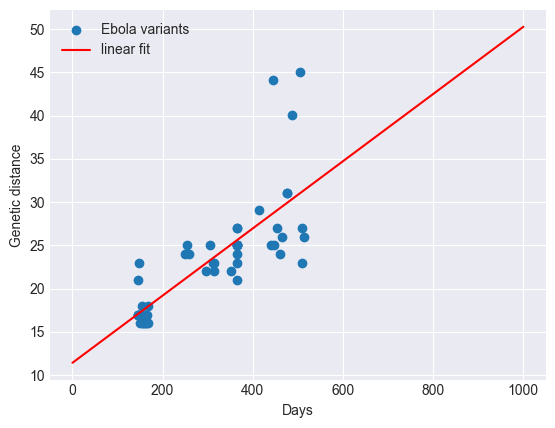

In [23]:
plt.style.use('seaborn-darkgrid')
plt.scatter(ebola_day_diffs, ebola_distances, label="Ebola variants")
plt.plot(lin, (ebola_coef[1] + lin*ebola_coef[0]), color="red", label="linear fit")
plt.xlabel("Days")
plt.ylabel("Genetic distance")
plt.legend(loc="upper left")

In [14]:
zika_day_diffs, zika_distances, zika_sequences = procedure("p2-zika-viruses.fasta", ignore_reference=True)
zika_coef = np.polyfit(zika_day_diffs, zika_distances, 1)
lin = np.linspace(0, 1000, 2)

In [15]:
zika_coef[0]

0.034011086547613555

In [16]:
zika_coef[0] / len(zika_sequences[0])

3.204964808482242e-06

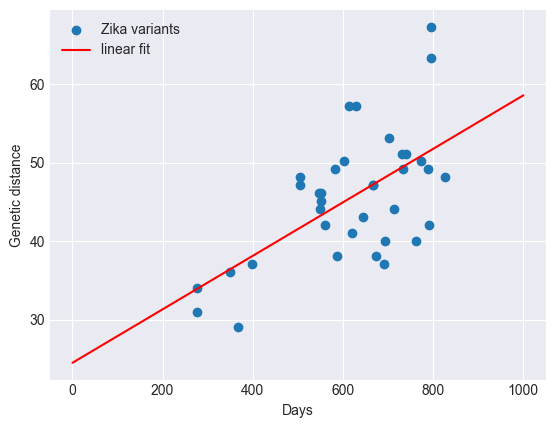

In [24]:
plt.style.use('seaborn-darkgrid')
plt.scatter(zika_day_diffs, zika_distances, label="Zika variants")
plt.plot(lin, (zika_coef[1] + lin*zika_coef[0]), color="red", label="linear fit")
plt.xlabel("Days")
plt.ylabel("Genetic distance")
plt.legend(loc='upper left')

In [17]:
ebola_per_genome_per_day = 0.03882462935132898
ebola_per_nt_per_day = 2.091618863879376e-06

zika_per_genome_per_day = 0.034011086547613555
zika_per_nt_per_day = 3.204964808482242e-06

In [27]:
ebola_per_genome_per_day / sars_cov_2_per_genome_per_day

0.6055238793684535

In [28]:
zika_per_nt_per_day / sars_cov_2_per_nt_per_day

1.4847301807177145

In [29]:
mutation_comments = """Looking at the mutation rates, we can see that sars_cov_2 is mutating faster than the other 2 viruses if we are looking at 
genome per day ratios. But if take sequence lengths into account we can see that covid is mutating approximately at the same rate as ebola virus and slower than zika virus.
We explain this by the amount of infected people by the virus.
"""

## Problem 3: Variant-specific mutations

As the virus mutates, it inevitably evolves and proliferates around the world. Every so often, some mutations may prove especially beneficial to the spread of the virus, and this version of the virus spreads faster than other versions. When a version of a virus becomes especially prevalent inside a population, we call this a virus *variant*. Variants are nothing more than a naming scheme for viruses that have specific mutations. For instance, in Slovenia, we are currently dealing with the Omicron variant. Think of this as observing natural selection in real time. Some viruses have mutations that enable them to spread more easily throughout our population, which inevitably leads to the demise of other virus variants, which are not as good at proliferation. The result is survival of the fittest at the viral level, where, unfortunately, the fittest viruses seem to cause the most damage to us humans.

How do we identify variants? A variant is determined by several so-called *defining mutations*. Mutations can either be synonymous or nonsynonymous. Synonymous mutations are changes in nucleotide bases that result in the same encoded amino acid and are thus less important. Nonsynonymous mutations are nucleotide mutations that alter the amino acid sequence of a protein.

To determine mutations, we first have to select a reference genome, which we will say has no mutations. In most cases, this is the first known occurrence of the virus, but in our case, the reference NCBI genome from Wuhan in 2019 (_NC_045512.2_).
Then, we align each viral genome of interest to this reference genome. All the differences between the reference genome and the genome of interest are said to be mutations.

To get a sense of the distribution of mutations across the genome in a variant, we will observe the most common mutations in **Alpha** (20I (Alpha, V1)) and **Delta** (21A (Delta)) variants. We will then try to answer whether the Delta variant emerged from the Alpha variant or evolved independently from a different strain of the virus.

**Task:**
Use pre-aligned sequences from the file `data/p1-sars-cov-2-variants.fasta`. To facilitate indexing, the reference sequence in the alignment has no indels. Extract the Alpha and Delta variants according to the indices in lists `alpha_variants` and `delta_variants`, respectively.

Calculate the Hamming distance between each sequence and the reference. For both variants, the average mutation rate for each nucleotide to get an array of mutation occurrences between 0 and 1.

Plot the mutation occurrences across the whole genome for the Alpha and Delta variants separately on one figure. Use _plt.plot_ to show the mutation occurrence. Focus on the part of the genome above the 20000 nucleotides and mark locations of the SARS-CoV-2 genes. You can find gene locations in the `gene_locations` variable. Expect a few sites with occurrence one and the rest close to zero.

We say a mutation is vital if its occurrence is higher than 0.5. Find all vital mutations in the spike gene ("S") and compare results between variants. There are a few sites where both variants mutated, but only one where the same mutation occurred.

Store your plot in the `problem3.png` and make it visually appealing.
Find indices of each site on the S gene where mutations occurred in both variants. Store integer sites into a `mutations_in_both_variants` variable where the site refers to the nucleotide in the reference genome.
Store the only same mutation into the `same_mutation` variable as a string denoting reference nucleotide, mutation site, and the variant nucleotide (e.g. "G123A", where G on position 123 in the reference mutates into an A.)

Write your comments in the `variant_comments` variable. Did the Delta variant evolve from Alpha? Why are there mutations that are not present in both variants? Why are they not distributed uniformly? What can we say about sites with no detected mutations?

**[10 points]**

In [25]:
gene_locations = {
    'S': (21462, 25284),
    'E': (26144, 26372),
    'M': (26422, 27091),
    'N': (28173, 29433)
}

alpha_variants  = ['EPI_ISL_2789189', 'EPI_ISL_2789042', 'EPI_ISL_1491060', 'EPI_ISL_1402029', 'EPI_ISL_6950370',
                    'EPI_ISL_1625411', 'EPI_ISL_1335421', 'EPI_ISL_2644151', 'EPI_ISL_2982899', 'EPI_ISL_2644156',
                    'EPI_ISL_2788965', 'EPI_ISL_2789059', 'EPI_ISL_2532608', 'EPI_ISL_2644516', 'EPI_ISL_2886579',
                    'EPI_ISL_3316487', 'EPI_ISL_2886574', 'EPI_ISL_2532626', 'EPI_ISL_2886496', 'EPI_ISL_2492172',
                    'EPI_ISL_2644108', 'EPI_ISL_1402024', 'EPI_ISL_2492224', 'EPI_ISL_2491984', 'EPI_ISL_2789018',
                    'EPI_ISL_2886831', 'EPI_ISL_1491132', 'EPI_ISL_2492034', 'EPI_ISL_1266392', 'EPI_ISL_2983056']

delta_variants = ['EPI_ISL_3039380', 'EPI_ISL_4271386', 'EPI_ISL_5213082', 'EPI_ISL_3316705','EPI_ISL_3316997',
                    'EPI_ISL_4251175', 'EPI_ISL_3471254', 'EPI_ISL_4271571', 'EPI_ISL_4270964', 'EPI_ISL_3317189',
                    'EPI_ISL_3829145', 'EPI_ISL_3317102', 'EPI_ISL_4923915', 'EPI_ISL_3829384', 'EPI_ISL_4923898',
                    'EPI_ISL_4270689', 'EPI_ISL_4270627', 'EPI_ISL_3828666', 'EPI_ISL_4253193', 'EPI_ISL_3828993',
                    'EPI_ISL_3039412', 'EPI_ISL_4923029', 'EPI_ISL_4251446', 'EPI_ISL_4271300', 'EPI_ISL_4271597',
                    'EPI_ISL_4271322', 'EPI_ISL_4922967', 'EPI_ISL_4251202', 'EPI_ISL_4251164', 'EPI_ISL_4270961',
                    'EPI_ISL_4270530', 'EPI_ISL_4270924', 'EPI_ISL_3829530', 'EPI_ISL_3828321', 'EPI_ISL_4271408',
                    'EPI_ISL_4271598', 'EPI_ISL_4924026', 'EPI_ISL_3316743']

In [26]:
records = list(SeqIO.parse("./data/p1-sars-cov-2-variants.fasta", "fasta"))
alpha_seqeunces = []
delta_seqeunces = []
for r in records:
    if r.description.split("|")[0] == "NC_045512.2": reference = r.seq
    if r.description.split("|")[0] in alpha_variants: alpha_seqeunces.append(r.seq)
    if r.description.split("|")[0] in delta_variants: delta_seqeunces.append(r.seq)

In [41]:
def calc_avg_nucleotide_mutation_rate(reference, variants):
    n = len(reference)
    avg_nucleotide_mutation_rate = np.zeros(len(reference))
    for i in range(n):
        ref_nuc = reference[i]
        for v in variants:
            if ref_nuc != v[i]:
                avg_nucleotide_mutation_rate[i] += 1
    return avg_nucleotide_mutation_rate / len(variants)

In [46]:
alpha_mutation_rate = calc_avg_nucleotide_mutation_rate(reference, alpha_seqeunces)
delta_mutation_rate = calc_avg_nucleotide_mutation_rate(reference, delta_seqeunces)

alpha_spike_mr = alpha_mutation_rate[gene_locations['S'][0]:gene_locations['S'][1]]
delta_spike_mr = delta_mutation_rate[gene_locations['S'][0]:gene_locations['S'][1]]

In [54]:
np.logical_and(alpha_spike_mr > 0.5,delta_spike_mr > 0.5).nonzero()

(array([1840, 2041], dtype=int64),)

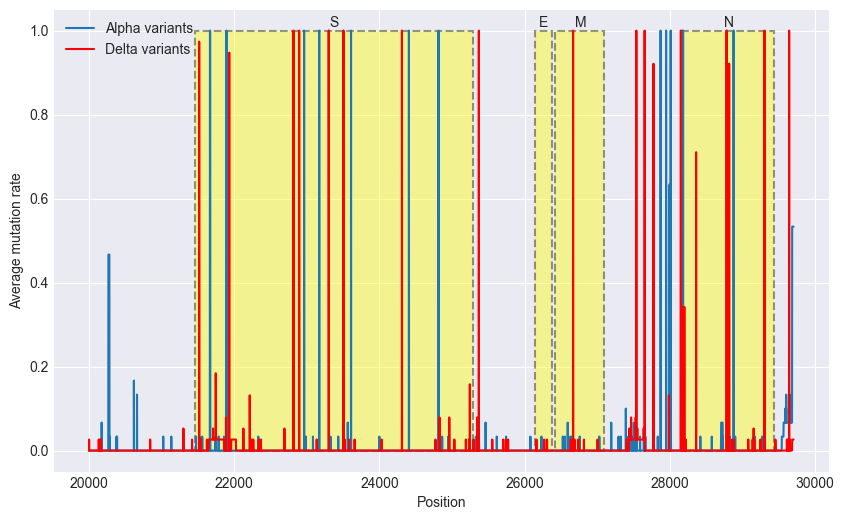

In [127]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6))
s = plt.Rectangle((gene_locations['S'][0],0), gene_locations['S'][1]-gene_locations['S'][0], 1, fc='yellow', alpha=0.4, linestyle = "dashed", ec='black', linewidth=1.5)
e = plt.Rectangle((gene_locations['E'][0],0), gene_locations['E'][1]-gene_locations['E'][0], 1, fc='yellow', alpha=0.4, linestyle = "dashed", ec='black', linewidth=1.5)
m = plt.Rectangle((gene_locations['M'][0],0), gene_locations['M'][1]-gene_locations['M'][0], 1, fc='yellow', alpha=0.4, linestyle = "dashed", ec='black', linewidth=1.5)
n = plt.Rectangle((gene_locations['N'][0],0), gene_locations['N'][1]-gene_locations['N'][0], 1, fc='yellow', alpha=0.4, linestyle = "dashed", ec='black', linewidth=1.5)
plt.text((gene_locations['S'][0] + gene_locations['S'][1]) / 2 - 60, 1.01, "S")
plt.text((gene_locations['E'][0] + gene_locations['E'][1]) / 2 - 60, 1.01, "E")
plt.text((gene_locations['M'][0] + gene_locations['M'][1]) / 2 - 60, 1.01, "M")
plt.text((gene_locations['N'][0] + gene_locations['N'][1]) / 2 - 60, 1.01, "N")
plt.gca().add_patch(s)
plt.gca().add_patch(e)
plt.gca().add_patch(m)
plt.gca().add_patch(n)
plt.plot(range(len(reference))[20000:], alpha_mutation_rate[20000:], label="Alpha variants")
plt.plot(range(len(reference))[20000:], delta_mutation_rate[20000:], label="Delta variants", color="red")
plt.xlabel("Position")
plt.ylabel("Average mutation rate")
plt.legend(loc="upper left")
plt.savefig("problem3.png", dpi=500, bbox_inches="tight")

In [ ]:
mutations_in_both_variants = [23302, 23503]
same_mutation = "A23302G" # write your mutation in the form of f"{reference nt}{site number}{variant nt}"

In [ ]:
variant_comments="""Since there are no common mutations, we deduce that delta did not evolve from alpha.
"""

## Problem 4: Identifying variants

As we've seen, mutations are not distributed uniformly across the genome. Important mutations at specific sites distinguish variants from each other. Nonsynonymous mutations are the ones reflected in the proteins they produce.

A standard convention is to denote mutations using a short string, e.g., *S:T 19 R*. The first part denotes the protein where the mutation has occurred. The second part is comprised of the actual mutation. For instance, *S:T 19 R* means that we are looking at a mutation on the S -- spike protein, where the original amino acid at location 19 was T -- threonine, which changed to R -- arginine. The "-" symbol indicates a deletion (e.g., *S:H 69 -*). For a complete reference of SARS-CoV-2 mutations, you can take a look at https://covariants.org and look through the different variants. We will not consider insertions in this homework, as it would only complicate our lives.

The folks over at the Clinical Institute of Special Laboratory Diagnostics have been kind enough to provide us with SARS-CoV-2 sequences from Slovenia for more than two years of the pandemic. In this homework, we will take a handful of these SARS-CoV-2 genomes from Slovenia and look at how the different variants spread throughout our country over time.
We will again focus on the spike protein sequence as this will speed up computation.
Additionally, the spike protein sequence is the most interesting in terms of variants, as mutations on the spike protein directly affect its ability to spread throughout our population and potentially get around our vaccination efforts.

**Task**

You have 747 pre-aligned SARS-CoV-2 spike protein sequences collected from Slovenia at various time points (`data/p4-slo-spike-proteins.fasta`). Your job is to determine the variant of each spike protein sequence. We have also prepared a JSON file (*variants.json*) containing all the information on SARS-CoV-2 variants that you'll need in this homework. Use the variant names and nonsynonymous mutations defined in this file for your classification. We have removed some of the variants for the purposes of this homework.

Your task is to look through each of the provided SARS-Cov-2 sequences and assign it to a variant.
To assign a variant, count the number of corresponding mutations on the spike protein sequence.
Assign the variant to a sequence with the highest percentage of matching mutations to a given variant. If all the variants have a match rate lower or equal to 50%, then you should assign the genome to the *UNKNOWN* class. If a sequence has no mutations, assign it to the *NO_MUTATIONS* class. If there is a tie, assign whichever variant. Save your answers to `problem4-classification.csv`. This file should contain two columns. The first column should indicate the accession id, e.g., *EPI_ISL_635200*, while the second column should indicate the variant display name (as specified in variants.json), e.g., *20I (Alpha, V1)* or *21K (Omicron)*. The CSV file should have no header. **[5 points]**

After you have assigned all the sequences to a variant, create a plot showing the change in distribution over time. More concretely, we have given you up to 30 sequences per month. Calculate the percentage of each variant in each month, and plot the distribution over time. Your plots should resemble https://covariants.org/per-country, which you can use to validate your work. Note that your plot will probably have a lot of *UNKNOWN* viral assignments. Save your figure into `problem4.png`. **[5 points]** 

**Hints**: Use [`plt.stackplot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.stackplot.html) for plotting. You might also find the pandas [`Grouper`](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html) class helpful when calculating percentages per month.

We will use a function `pd.read_csv("problem4-classification.csv", sep=",", header=None)` to read your classification file, so you can test the correct format.

**Notes**:

1. Due to the fast nature of the sequencing done in these sequences, some sequences may contain the character "X". This character does not denote some new amino acid but means that the sequencing was ambiguous and/or that the amino acid wasn't able to be determined. Ignore any positions with the "X" character, and do not count them toward mutations.

3. Although you could perform the alignment yourself with the algorithms you implemented in Homework 2, in this exercise, we have already pre-aligned the viral genomes for you to avoid any long-running computation. In this homework, we will only consider substitutions and deletions, and we will ignore insertions. Insertions would needlessly complicate mutation indexing. Additionally, almost none of the variants for SARS-CoV-2 are determined by insertions, so we can ignore them.

In [39]:
records = list(SeqIO.parse("./data/p1-sars-cov-2-variants.fasta", "fasta"))
for r in records:
    if r.description.split("|")[0] == "NC_045512.2": reference = r.seq[21462:25284].translate()

In [40]:
f = open('./data/variants.json')
data = json.load(f)
f.close()

real_data = {}
for k, v in data.items():
    real_data[k] = {}
    for k2,v2 in v.items():
        if k2 == 'nonsynonymous':
            for gene in v2:
                if gene['gene'] == 'S': real_data[k][gene['pos']] = gene['right']

In [41]:
records = list(SeqIO.parse(f'./data/p4-slo-spike-proteins.fasta', "fasta"))
accessions = []
variants = []
dates = []
for r in records:
    accessions.append(r.description.split("|")[1])
    dates.append(pd.to_datetime(r.description.split("|")[2]))
    if r.seq == reference: 
        variants.append("NO_MUTATIONS")
        continue
    final_percent = 0
    variant = ''
    for k, v in real_data.items():
        percent = 0
        sequence = r.seq
        for k2, v2 in v.items():
            if sequence[k2-1] == v2: percent += 1
        percent /= len(v)
        if percent > final_percent:
            final_percent = percent
            variant = k
    if final_percent > 0.5: variants.append(variant)
    else: variants.append("UNKNOWN")

In [127]:
df = pd.DataFrame({"variants": variants, "accessions": accessions, "date":dates})
# df
df.to_csv("problem4-classification.csv", header=False)

In [113]:
monthly = df.groupby([pd.Grouper(key="date", freq='M')], as_index=False)["variants"].value_counts(normalize=True)
monthly.date = monthly.date.apply(lambda dt: dt.replace(day=1))
# monthly

In [115]:
unique_dates = np.unique(monthly.date)
unique_variants = {v:[] for v in np.unique(monthly.variants)}
for d in unique_dates:
    this_month_variants = monthly[monthly.date == d].variants.values
    for v in unique_variants:
        if v in this_month_variants: 
            unique_variants[v].append(monthly.proportion[(monthly.variants == v) & (monthly.date == d)].values[0])
        else:
            unique_variants[v].append(0)

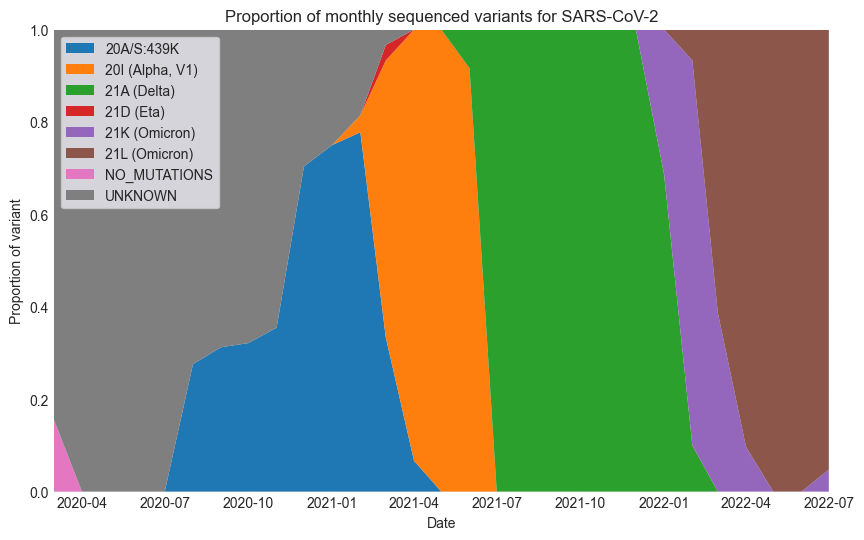

In [118]:
from matplotlib.pyplot import figure
plt.style.use('seaborn-darkgrid')
figure(figsize=(10, 6))
plt.stackplot(unique_dates, unique_variants.values(), labels=unique_variants.keys())
plt.margins(0,0)
plt.ylabel("Proportion of variant")
plt.xlabel("Date")
plt.legend(loc='upper left', frameon=True)
plt.title("Proportion of monthly sequenced variants for SARS-CoV-2")
# plt.savefig("problem4.png", dpi=500, bbox_inches="tight")

## Bonus 1: Kimura two-parameter correction (K2P)

Kimura's two-parameter model is a more elaborate approach to correcting genetic distances. It assumes that transitions are four times less likely to occur than transversion, thus weighing those substitutions differently. The model still ignores insertions and deletions.

**Task:**
Implement `kimura_two_parameter` in the `helper_functions.py` to calculate the Kimura correction of genetic distance.
Recalculate the mutation rate for SARS-CoV-2 as in Problem 1, this time with Kimura's corrected distances. Follow the same protocol from Problem 1 and store both mutation rates into their appropriate variables `sars_cov_2_per_genome_per_day_kp2` and `sars_cov_2_per_nt_per_day_k2p`, respectively.
Comment on the difference between Jukes-Cantor and Kimura corrections and how this difference shows in our case. Save your comment into the `kimura_comment` variable.
**[10 points]**

In [ ]:
# TODO

In [ ]:
sars_cov_2_per_genome_per_day_kp2 = 0.0
sars_cov_2_per_nt_per_day_k2p = 0.0

In [ ]:
kimura_comment = """
"""